[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/ZAGamma_simulation_example.ipynb)

# Imports

In [13]:
from lightgbmlss.model import *
from lightgbmlss.distributions.ZAGamma import *

from sklearn.model_selection import train_test_split
import pandas as pd
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)

# Data

In [2]:
# The simulation example closely follows https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af
np.random.seed(123)
n_samples = 1000

data = pd.DataFrame({"age": np.random.randint(1, 100, size=n_samples)})
data["income"] = np.where((data.age > 17) & (data.age < 70), 1500*data.age + 5000 + 10000*np.random.randn(n_samples), 0) / 1000

y = data["income"].values
X = data.drop(columns="income")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Zero-Adjusted Gamma distribution. See ?ZAGamma for an overview.
lgblss = LightGBMLSS(
    ZAGamma(stabilization="None",        # Options are "None", "MAD", "L2".
            response_fn="exp",           # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
            loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).)      
           )           
)

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=10,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-06-15 15:14:13,557] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS-Dam57Fpb\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-15 15:14:20,833] Trial 0 finished with value: 482.74905218409265 and parameters: {'eta': 0.0007827351393686609, 'max_depth': 7, 'min_gain_to_split': 9.932088035001692, 'min_sum_hessian_in_leaf': 1.478272107303684, 'subsample': 0.35522525989479314, 'feature_fraction': 0.7498566192676195, 'boosting': 'gbdt'}. Best is trial 0 with value: 482.74905218409265.
[I 2023-06-15 15:14:22,787] Trial 1 finished with value: 377.2688005093256 and parameters: {'eta': 0.0768183230622622, 'max_depth': 5, 'min_gain_to_split': 30.21298002460192, 'min_sum_hessian_in_leaf': 1.0409165696630063e-05, 'subsample': 0.24409217093749175, 'feature_fraction': 0.8678183171433698, 'boosting': 'gbdt'}. Best is trial 1 with value: 377.2688005093256.
[I 2023-06-15 15:14:25,239] Trial 2 finished with value: 363.8335318317436 and parameters: {'eta': 0.08772415321825192, 'max_depth': 9, 'min_gain_to_split': 9.729531232670183, 'min_sum_hessian_in_leaf': 2.1803152128037972e-06, 'subsample': 0.7696236623696768, 'fea

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,123.438103,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,56.564182,90.570610,76.759865,92.745216,124.687424,148.876938,128.478897,42.867249,149.097504,100.765228,...,71.179710,46.398308,72.961731,85.703423,131.566986,117.870827,67.155853,96.793266,130.013855,75.595924
2,50.357327,38.009308,48.129627,28.329327,35.387333,66.233910,39.689926,56.149670,32.366734,55.446510,...,31.972153,42.318722,35.019489,39.267368,48.579967,20.919867,102.851501,51.818890,42.165047,68.717339
3,27.514729,31.467215,51.011265,50.890095,61.320950,79.408607,48.455315,64.924301,34.599098,47.402710,...,43.177628,49.564522,57.908436,38.591694,76.923431,64.848831,73.037727,52.246223,47.472324,48.130749
4,0.000000,0.000000,0.000000,59.672607,0.000000,35.400860,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.000000,0.000000
1,42.923942,146.371653
2,15.951617,77.795721
3,25.436746,102.843029
4,0.000000,0.000000


In [9]:
pred_params.head()

,concentration,rate,gate
0,8.946457,0.092902,0.971570
1,8.699142,0.092902,0.025223
2,6.200342,0.141521,0.025223
3,6.838458,0.116799,0.025223
4,6.200342,0.152351,0.971570


# SHAP Interpretability

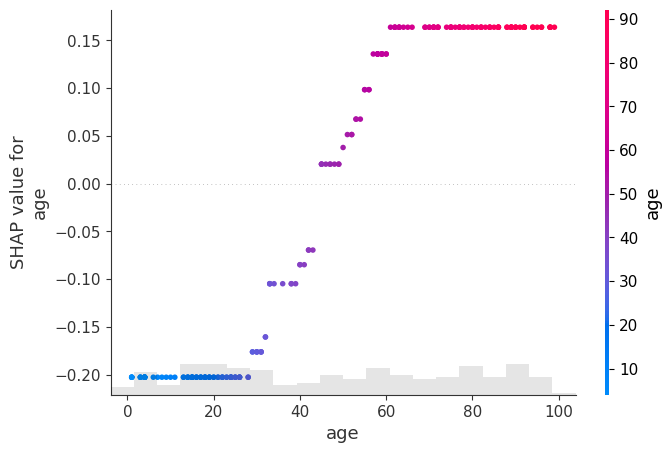

In [10]:
# Partial Dependence Plot of concentration parameter
lgblss.plot(X_test,
            parameter="concentration",
            feature="age",
            plot_type="Partial_Dependence")

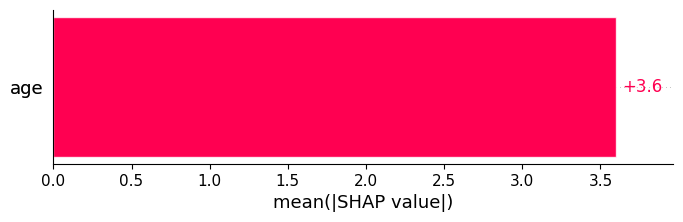

In [11]:
# Feature Importance of gate parameter
lgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

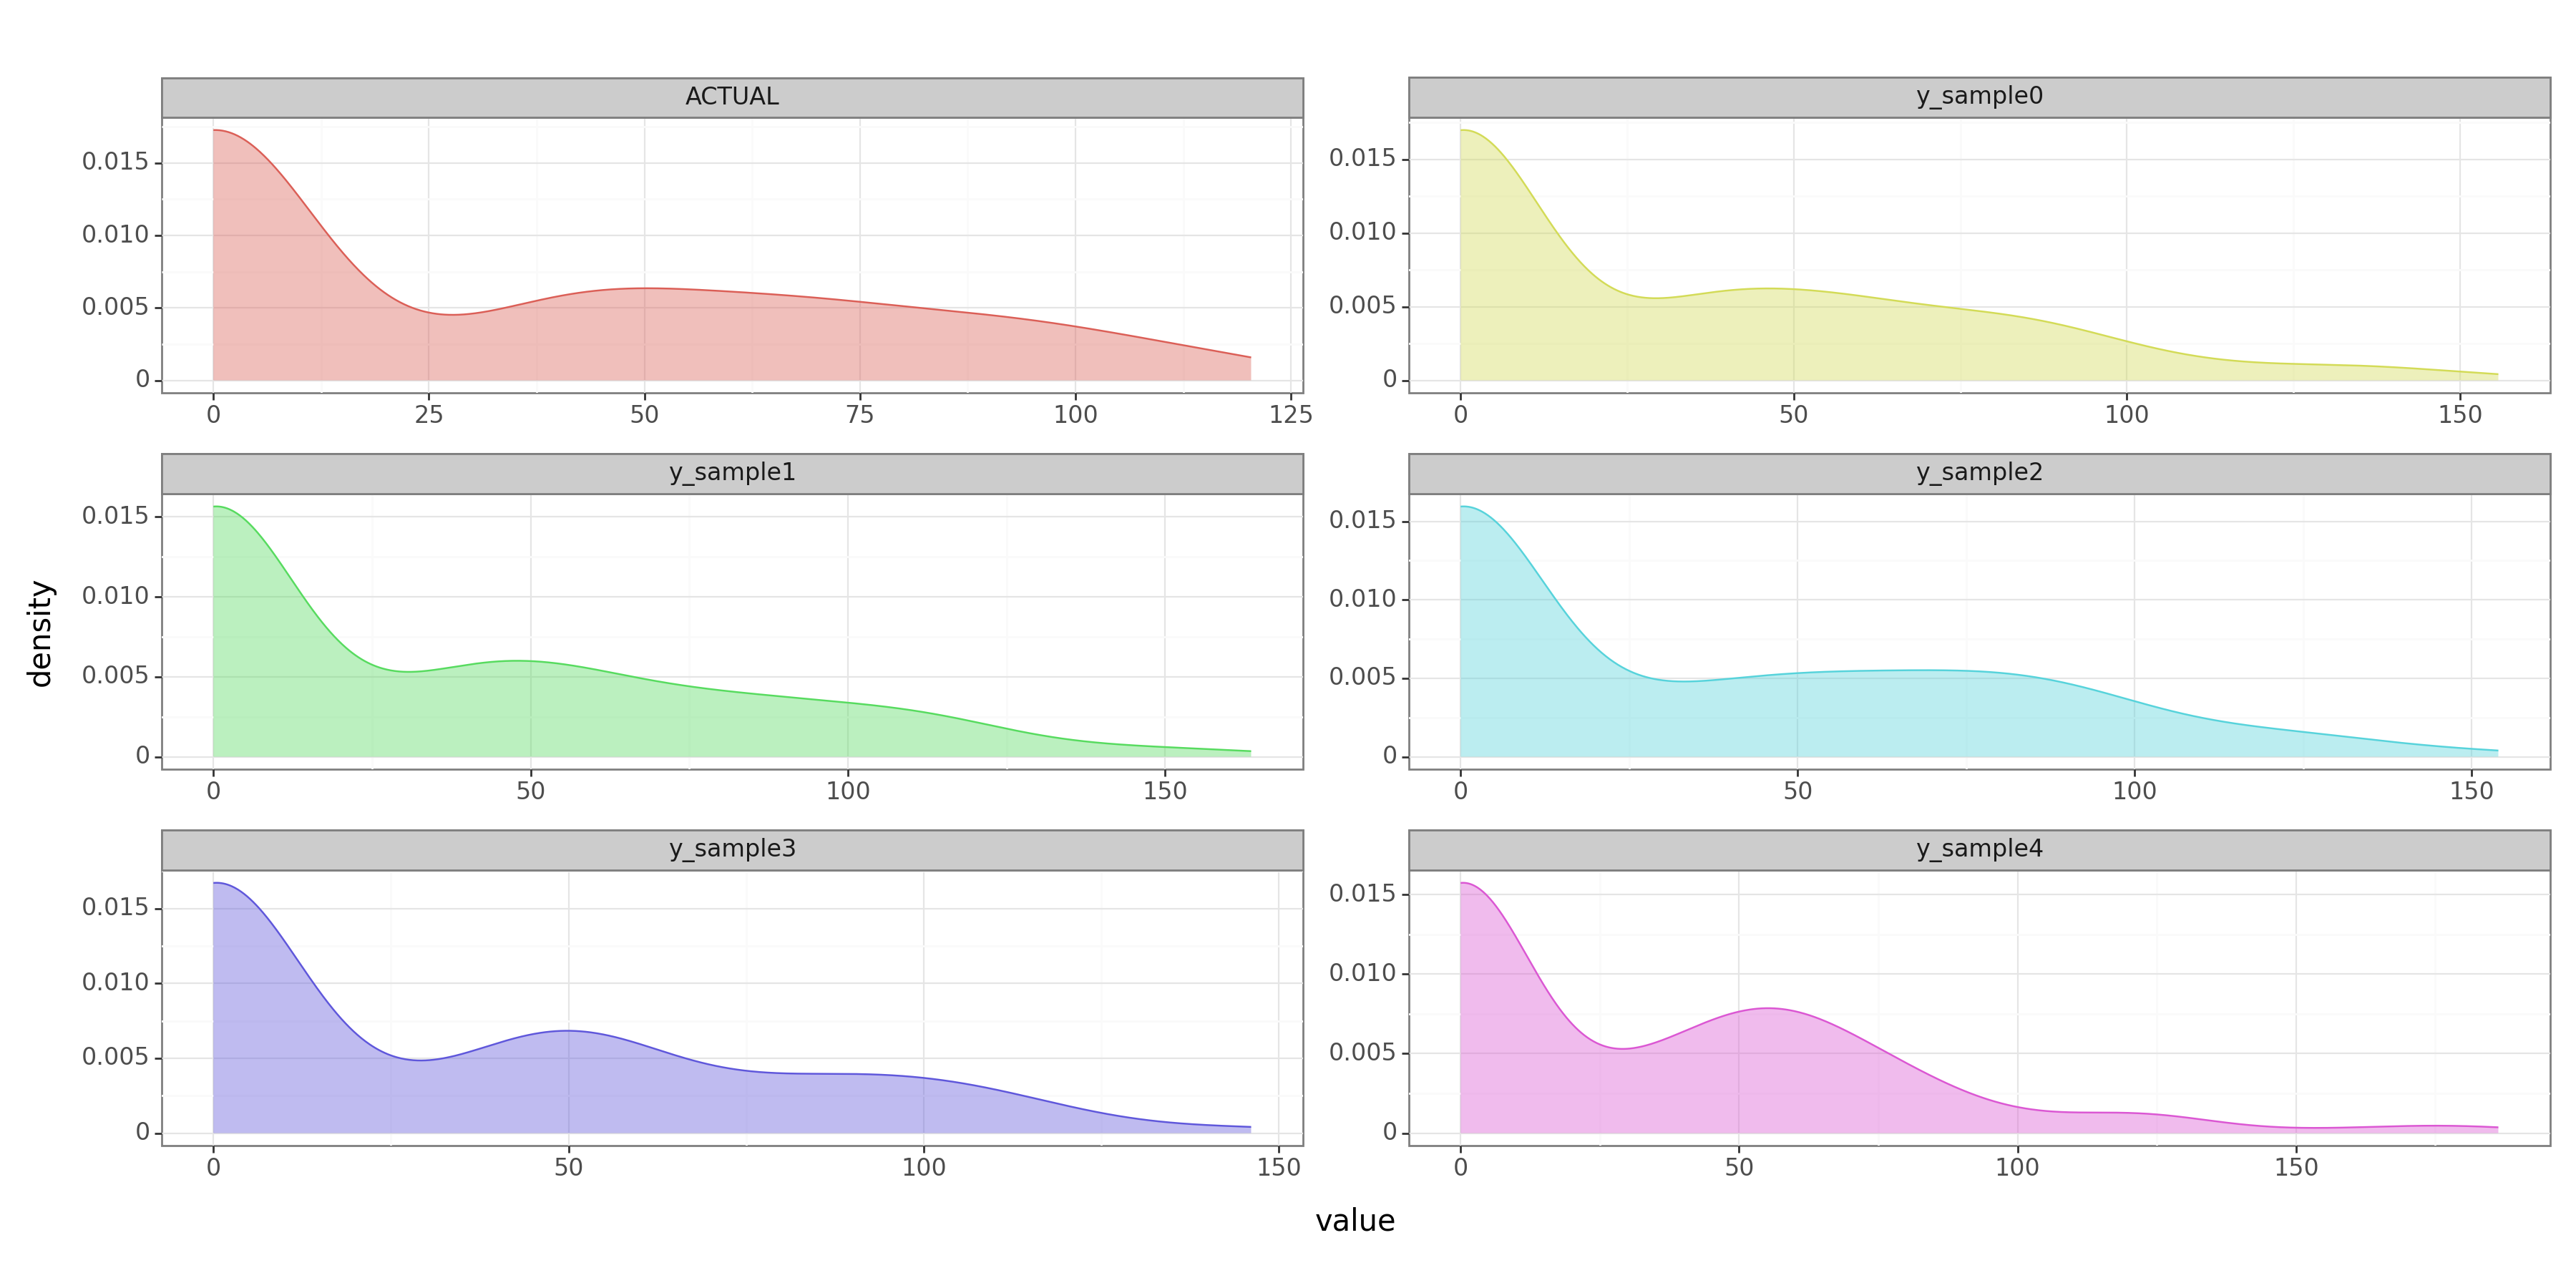

<Figure Size: (1800 x 900)>

In [12]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)